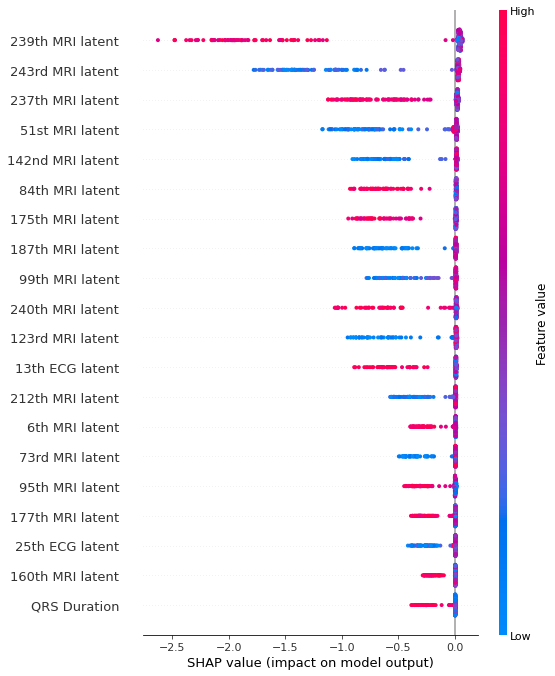

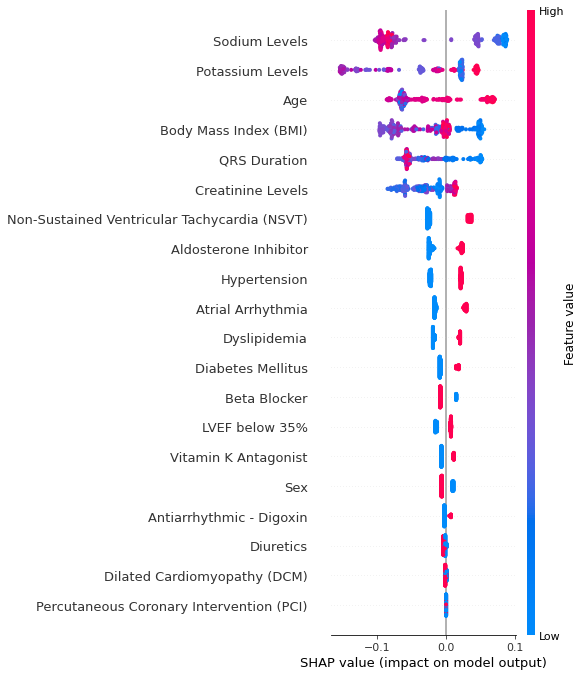

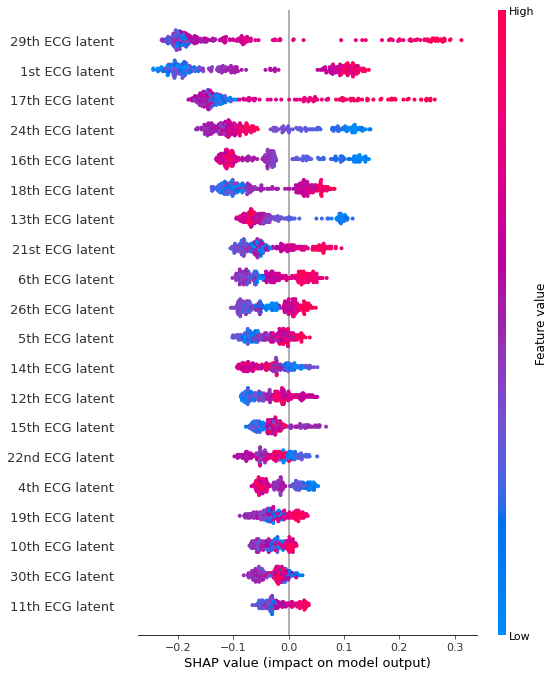

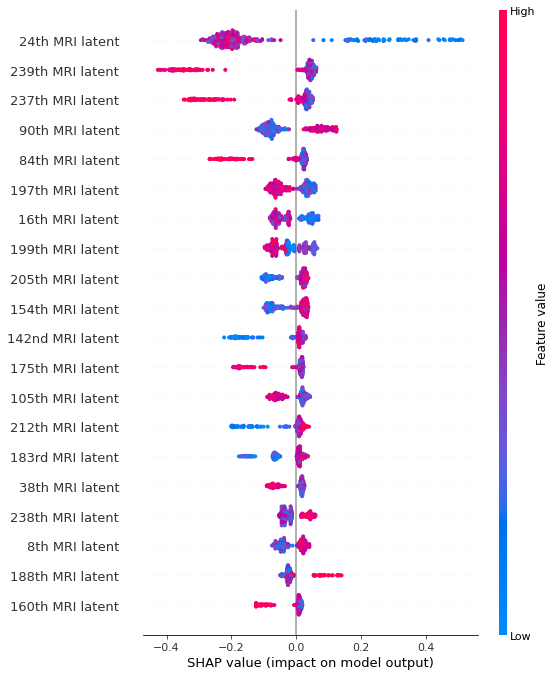

In [1]:
import pickle
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, average_precision_score
from performance_calcul import *
import json
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

with open('overall_model.pkl', 'rb') as model_file:
    overall_model = pickle.load(model_file)
with open('best_model_clin.pkl', 'rb') as model_file:
    best_model_clin = pickle.load(model_file)
with open('best_model_mri.pkl', 'rb') as model_file:
    best_model_mri = pickle.load(model_file)
with open('best_model_ecg.pkl', 'rb') as model_file:
    best_model_ecg = pickle.load(model_file)
    
overall_X_data = np.load('overall_X_data.npy')
overall_y_data = np.load('overall_y_data.npy')
all_mri_grad = np.load('all_mri_grad_rev.npy')
all_ecg_grad = np.load('all_ecg_grad_rev.npy')

X_test_all= np.load('X_test_all.npy')
y_testing = np.load('test_labels.npy')
y_test = y_testing[:, 0]

def ordinal_number(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return str(n) + suffix

clinical_feature_names = ['Age', 'Sex', 'Dilated Cardiomyopathy (DCM)', 'LVEF below 35%', 
                          'Body Mass Index (BMI)', 'Atrial Arrhythmia', 'Non-Sustained Ventricular Tachycardia (NSVT)', 
                          'Hypertension', 'QRS Duration', 'Sustained Ventricular Tachycardia (SustVT)', 'Percutaneous Coronary Intervention (PCI)', 
                          'Coronary Artery Bypass Grafting (CABG)', 'Myocardial Infarction', 'Cerebrovascular Accident (CVA)', 'Chronic Obstructive Pulmonary Disease (COPD)', 
                          'Diabetes Mellitus', 'Sodium Levels', 'Potassium Levels', 'Creatinine Levels', 'Vitamin K Antagonist', 
                          'Antiarrhythmic - Sotalol', 'Antiarrhythmic - Digoxin', 'LVEF between 35%-45%', 
                          'Non-Ischemic Cardiomyopathy (NICM)', 'Hypertrophic Cardiomyopathy (HCM)', 'Paroxysmal Atrial Fibrillation (PAF)', 
                          'Coronary Heart Disease (CHD)', 'Dyslipidemia', 'Aldosterone Inhibitor', 'Antiarrhythmic - Amiodarone', 
                          'Beta Blocker', 'Novel Oral Anticoagulant (NOAC)', 'Diuretics']

mri_latent_feature_names = [ordinal_number(i) + " MRI latent" for i in range(0, 256)]
ecg_latent_feature_names = [ordinal_number(i) + " ECG latent" for i in range(0, 32)]
feature_names = clinical_feature_names +  ecg_latent_feature_names + mri_latent_feature_names

overall_Xclin_data_df = pd.DataFrame(overall_X_data, columns=feature_names)
explainer = shap.TreeExplainer(overall_model)
shap_values = explainer(overall_Xclin_data_df)
shap.summary_plot(shap_values)

with open('clin_params.json', 'r') as file:
    clin_params = json.load(file)

overall_Xclin_data_df = pd.DataFrame(overall_X_data[:, 0:33], columns=clinical_feature_names)
best_model_clin = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **clin_params)
best_model_clin.fit(overall_Xclin_data_df, overall_y_data)
explainer = shap.TreeExplainer(best_model_clin)
shap_values = explainer(overall_Xclin_data_df)
shap.summary_plot(shap_values, show=False)

plt.show()
plt.close()

with open('ecg_params.json', 'r') as file:
    ecg_params = json.load(file)
    
overall_Xclin_data_df = pd.DataFrame(overall_X_data[:, 33:65], columns=ecg_latent_feature_names)
best_model_ecg = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **ecg_params)
best_model_ecg.fit(overall_Xclin_data_df, overall_y_data)
explainer = shap.TreeExplainer(best_model_ecg)
shap_values = explainer(overall_Xclin_data_df)
shap.summary_plot(shap_values, show=False)
plt.show()
plt.close()

with open('mri_params.json', 'r') as file:
    mri_params = json.load(file)
    
overall_Xclin_data_df = pd.DataFrame(overall_X_data[:, 65:], columns=mri_latent_feature_names)
best_model_mri = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **mri_params)
best_model_mri.fit(overall_Xclin_data_df, overall_y_data, )
explainer = shap.TreeExplainer(best_model_mri)
shap_values = explainer(overall_Xclin_data_df)
shap.summary_plot(shap_values, show=False)

plt.show()
plt.close()


# Load VAEs

In [2]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics._ranking")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module="sklearn.metrics._ranking")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning, module="sklearn.metrics._classification")

seed_value = 1
torch.manual_seed(seed_value)
np.random.seed(seed_value)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


from VAEresnet_electrocar_2d import VAE, VAE_Loss
vae_ecg = VAE(latent_dim=32, red=1).to(device)
final_model_path = r"\VAE2d-ECG weights.pt"
vae_ecg.load_state_dict(torch.load(final_model_path))

from VAEres3d_mri_unsuper import *
vae_mri = VAE(latent_dim=256, red=1, drop=0).to(device)
path_weights = r'\\weights_vae_lge_256.pt'
vae_mri.load_state_dict(torch.load(path_weights))


<All keys matched successfully>

# Get most prognostic latents from SHAP

In [3]:
def ordinal_number(n):
    if 10 <= n % 100 <= 20:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return str(n) + suffix

clinical_feature_names = ['Age', 'Sex', 'DCM', 'LowLVEF', 'BMI', 'Atrial arrhythmia',
                          'NSVT', 'Hypertension', 'QRS Duration', 'SustVT', 'PCI', 'CABG', 'MyocardialInfarction', 
                          'CVA', 'COPD', 'DiabetesMellitus', 'Sodium', 'Potassium', 'Creatinine', 
                          'Vitamine_K', 'Antiaritmica_soort#Sotalol', 'Antiaritmica_soort#Digoxine', 
                          'ReducedLVEF', 'NICM', 'HCM', 'PAF', 'CHD', 'Dyslipedaemia', 
                          'Aldosterone inhibitor', 'Antiaritmica_soort#Amiodarone', 'Betablokker', 'NOAC', 
                          'Diuretica']

mri_latent_feature_names = [ordinal_number(i) + " MRI latent" for i in range(0, 256)]
ecg_latent_feature_names = [ordinal_number(i) + " ECG latent" for i in range(0, 32)]
feature_names = clinical_feature_names +  ecg_latent_feature_names + mri_latent_feature_names
overall_model.fit(overall_X_data, overall_y_data)

y_pred_proba = overall_model.predict_proba(overall_X_data)[:, 1]  # Use the predicted probabilities for the positive class
fpr_train, tpr_train, thresholds_train = roc_curve(overall_y_data, y_pred_proba)
youden_index_train = tpr_train - fpr_train
optimal_threshold_train = thresholds_train[np.argmax(youden_index_train)]
y_pred = (y_pred_proba >= optimal_threshold_train).astype(int)

explainer = shap.TreeExplainer(overall_model)
shap_values = explainer.shap_values(overall_X_data)

indices = np.where(overall_y_data == 1)[0]
print(indices)

[  3  16  34  37  60  79  80  93  97 103 104 112 117 123 124 127 146 153
 171 173 192 205 207 224 229 234]


# Shap of individual prediction

1


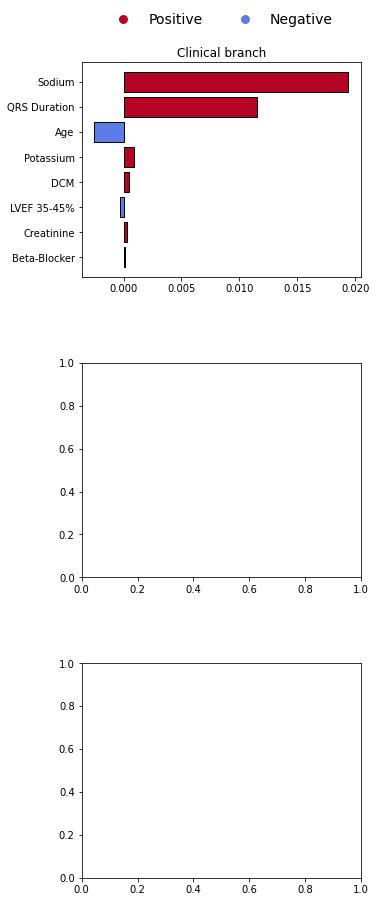

In [10]:
for sda in range(1,2):
    print(sda)
    patient_idx = sda
    num_colors = 10
    rd_bu_colormap = plt.get_cmap('coolwarm')
    values = np.linspace(0, 1, num_colors)
    colors = rd_bu_colormap(values)
    red_shade = colors[1]
    blue_shade = colors[-1]

    import matplotlib.pyplot as plt
    import shap
    import numpy as np

    def plot_shap_values(overall_model, overall_Xclin_data_df, patient_idx, start_idx, end_idx, ax, cat='branch'):
        explainer = shap.TreeExplainer(overall_model)
        shap_values = explainer(overall_Xclin_data_df)
        selected_features = overall_Xclin_data_df.iloc[:, start_idx:end_idx]
        shap_values.values = shap_values.values[:, start_idx:end_idx]
        shap_values.base_values = shap_values.data[:, start_idx:end_idx]
        shap_values.feature_names = shap_values.feature_names[start_idx:end_idx]

        sorted_indices = np.argsort(np.abs(shap_values.values[patient_idx, :]))
        sorted_feature_names = [shap_values.feature_names[i] for i in sorted_indices]
        sorted_values = shap_values.values[patient_idx, sorted_indices]
        sorted_values = sorted_values[-8:] 
        if len(shap_values.feature_names) == 33:
            modified_feature_descriptions = ['Age', 'Sex', 'DCM', 'LVEF <35%', 'Body Mass Index (BMI)',
                                                 'Atrial Arrhythmia', 'Non-Sustained Ventricular Tachycardia (NSVT)', 'Hypertension',
                                                 'QRS Duration', 'Sustained Ventricular Tachycardia (SustVT)',
                                                 'Percutaneous Coronary Intervention (PCI)', 'Coronary Artery Bypass Grafting (CABG)',
                                                 'Myocardial Infarction', 'Cerebrovascular Accident (CVA)',
                                                 'Chronic Obstructive Pulmonary Disease (COPD)', 'Diabetes Mellitus', 'Sodium',
                                                 'Potassium', 'Creatinine', 'Vitamin K Antagonist', 'Antiarrhythmic - Sotalol',
                                                 'Antiarrhythmic - Digoxin', 'LVEF 35-45%', 'Non-Ischemic Cardiomyopathy (NICM)',
                                                 'Hypertrophic Cardiomyopathy (HCM)', 'Paroxysmal Atrial Fibrillation (PAF)',
                                                 'Coronary Heart Disease (CHD)', 'Dyslipidemia', 'Aldosterone Inhibitor',
                                                 'Antiarrhythmic - Amiodarone', 'Beta-Blocker', 'Novel Oral Anticoagulant (NOAC)',
                                                 'Diuretics']

            sorted_feature_names = [modified_feature_descriptions[i] for i in sorted_indices]
        sorted_feature_names = sorted_feature_names[-8:]  # Adjust the slicing as needed

        colors = [red_shade if val < 0 else blue_shade for val in sorted_values]

        ax.barh(sorted_feature_names, sorted_values, color=colors, edgecolor="black", linewidth=1)
        ax.set_title(f'{cat}')

    fig, axs = plt.subplots(3, 1, figsize=(5, 15))
    overall_Xclin_data_df = pd.DataFrame(overall_X_data, columns=feature_names)
    plot_shap_values(overall_model, overall_Xclin_data_df, patient_idx, 0, 33, axs[0], cat='Clinical branch')
    legend_labels = ['Positive', 'Negative']
    legend_colors = [blue_shade, red_shade]
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_colors[i], markersize=10) for i in range(2)]
    legend = plt.legend(legend_handles, legend_labels, loc='center', fontsize=14, framealpha=0, ncol=2, bbox_to_anchor=(0.5, 4))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

# Get most prognostic MRI and ECG features

In [11]:
import pandas as pd
import shap
import numpy as np
import re

def analyze_shap_values(overall_model, overall_X_data, feature_names, patient_idx, top_n=10):
    overall_Xclin_data_df = pd.DataFrame(overall_X_data, columns=feature_names)
    explainer = shap.TreeExplainer(overall_model, overall_Xclin_data_df)
    shap_values = explainer.shap_values(overall_Xclin_data_df)
    vals = shap_values[patient_idx]
    shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                   columns=['col_name', 'feature_importance_vals'])

    shap_importance['abs_importance'] = shap_importance['feature_importance_vals'].abs()
    shap_importance.sort_values(by=['abs_importance'], ascending=False, inplace=True)
    mri_idx = [int(re.search(r'\d+', col).group()) for col in
               shap_importance[shap_importance['col_name'].str.contains('MRI')].head(top_n)['col_name']]
    ecg_idx = [int(re.search(r'\d+', col).group()) for col in
               shap_importance[shap_importance['col_name'].str.contains('ECG')].head(top_n)['col_name']]
    return mri_idx, ecg_idx

selected_mri, selected_ecg = analyze_shap_values(overall_model, overall_X_data, feature_names, patient_idx, top_n=10)
print("Selected MRI features:", selected_mri)
print("Selected ECG features:", selected_ecg)

Selected MRI features: [73, 154, 24, 199, 239, 237, 183, 90, 238, 16]
Selected ECG features: [22, 9, 18, 24, 29, 1, 12, 16, 20, 4]


# Make ECG GradCAM

In [17]:
from __future__ import print_function
from collections import OrderedDict
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os
import numpy as np 

def default_normalizer(x) -> np.ndarray:
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    scaler = ScaleIntensity(minv=0.0, maxv=1.0)
    x = [scaler(x) for x in x]
    return np.stack(x, axis=0)

class PropBase(object):
    def __init__(self, model, target_layer, cuda=True):
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    def encode_one_hot_batch(self,z, idx):
        one_hot_batch = torch.FloatTensor(z.size()).zero_()
        one_hot_batch[0][idx] = 1.0
        return one_hot_batch

    # back prop the one_hot signal
    def backward(self, z, idx):
        self.model.zero_grad()
        self.z = z 
        one_hot = self.encode_one_hot_batch(z, idx)# this returns mu
        if self.cuda:
            one_hot = one_hot.cuda()
        flag=2
        if flag == 1:
            self.score_fc = torch.sum(F.relu(one_hot * z))
        else:
            self.score_fc = z[0,idx] # backprop the selected z  
        self.score_fc.backward(retain_graph=True)
    
    def get_conv_outputs(self, outputs, target_layer): 
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:                        
                        return value
        raise ValueError('invalid layer name: {}'.format(target_layer))

class attribute_wise_attn(PropBase):
    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()
        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output
        for module in self.model.named_modules():
            module[1].register_backward_hook(func_b)
            module[1].register_forward_hook(func_f)
            
    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads)
        self.map_size = self.grads.size()[2:]
        self.weights = nn.AvgPool2d(self.map_size)(self.grads)
    def generate(self, device='cuda'):
        self.grads = self.get_conv_outputs(self.outputs_backward, self.target_layer)
        self.compute_gradient_weights()
        self.activation = self.get_conv_outputs(self.outputs_forward, self.target_layer)
        self.weights = self.weights.to(device).detach()
        cam = torch.zeros((self.activation.size(1), self.activation.size(2), self.activation.size(3)), dtype=torch.float32, device=device)
        
        for i, w in enumerate(self.weights[0]):
            cam += w * self.activation[0, i]
        epsilon = 1e-8
        cam = F.relu(cam)
        cam /= (torch.max(cam) + epsilon) 
        cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(1, 12, 210), mode='trilinear', align_corners=False)
        cam_resized = cam_resized[0, 0].cpu().detach().numpy()
        return cam_resized


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


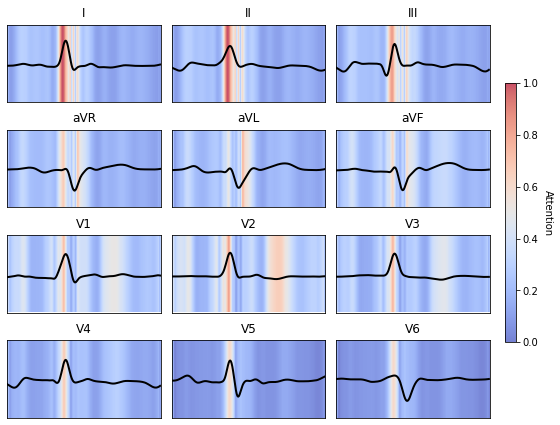

In [19]:
def visualize_attention_ecg(vae_ecg,ecgs, patient_id, latent_dimension_to_visualize, device,cmap_set = 'viridis', alpha_cmap = 1, threshold_cap_grad=0.5,multiple_latents=False, cap_on_grad=True, list_of_latents=[]):
    attention_visualizer = attribute_wise_attn(vae_ecg, target_layer='encoder.7', cuda=True)
    input_example = torch.tensor(ecgs[patient_id:patient_id+1,:,:]).to(device)
    input_example = input_example.to(torch.float32)
    
    x_recon, z_ecg, _, _ = vae_ecg(input_example)
    if multiple_latents == True:
        attention_maps = []
        for latent in list_of_latents:
            attention_visualizer.backward(z_ecg, latent)
            attention_map = attention_visualizer.generate()
            reshaped_attention_map = attention_map.reshape(12, 210)
            attention_maps.append(reshaped_attention_map)

        attention_maps = np.array(attention_maps)
        avg_attention_map = np.mean(attention_maps, axis=0)
        reshaped_attention_map = (avg_attention_map - np.min(avg_attention_map)) / (np.max(avg_attention_map) - np.min(avg_attention_map))
        
        if cap_on_grad:
            reshaped_attention_map = np.ma.masked_where(reshaped_attention_map <= threshold_cap_grad, reshaped_attention_map)
        
        x_recon = x_recon.cpu().detach().numpy()

        fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7,6))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

        signal = input_example.cpu().detach().numpy()
        lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
        
        for lead_idx, ax in enumerate(axes.flat):
            im = ax.imshow(np.expand_dims(reshaped_attention_map[lead_idx], axis=0), alpha=alpha_cmap, cmap=cmap_set, aspect='auto',
                           vmin=0, vmax=1, extent=[0, signal.shape[3], -0.5, 1.5])
            ax.plot(signal[0,0, lead_idx], color='black', alpha=1, linewidth=2)  
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_title(f'{lead_names[lead_idx]}', fontsize=12, y=1.02) 

        cbar_width = 0.02
        cbar_height = 0.6 
        cbar_padding = (1 - cbar_height) / 2  
        cbar_ax = fig.add_axes([1.01, cbar_padding, cbar_width, cbar_height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('Attention', rotation=270, labelpad=15)
        plt.tight_layout()
        plt.show()

visualize_attention_ecg(vae_ecg,
                     all_ecg_grad,
                     patient_id=patient_idx, cmap_set = 'coolwarm',
                     latent_dimension_to_visualize=0,cap_on_grad=False, threshold_cap_grad = 0.05,
                     device = 'cuda', alpha_cmap= .7,
                     list_of_latents=[22, 9, 18, 24, 29, 1, 12, 16, 20, 4], 
                     multiple_latents=True)

# Make MRI GradCAM 

In [20]:
from __future__ import print_function
from collections import OrderedDict
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os
import numpy as np
import torch
import numpy as np
import matplotlib.pyplot as plt

def default_normalizer(x) -> np.ndarray:
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    scaler = ScaleIntensity(minv=0.0, maxv=1.0)
    x = [scaler(x) for x in x]
    return np.stack(x, axis=0)

class PropBase(object):
    def __init__(self, model, target_layer, cuda=True):
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    def encode_one_hot_batch(self,z, idx):
        one_hot_batch = torch.FloatTensor(z.size()).zero_()
        one_hot_batch[0][idx] = 1.0
        return one_hot_batch

    def backward(self, z, idx):
        self.model.zero_grad()
        self.z = z 
        one_hot = self.encode_one_hot_batch(z, idx)# this returns mu
        if self.cuda:
            one_hot = one_hot.cuda()
        flag=2
        if flag == 1:
            self.score_fc = torch.sum(F.relu(one_hot * z))

        else:
            self.score_fc = z[0,idx] 
        self.score_fc.backward(retain_graph=True)
    
    def get_conv_outputs(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:                        
                        return value
        raise ValueError('invalid layer name: {}'.format(target_layer))

class attribute_wise_attn(PropBase):
    
    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()
        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output
        for module in self.model.named_modules():
            module[1].register_backward_hook(func_b)
            module[1].register_forward_hook(func_f)
    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads)
        self.map_size = self.grads.size()[2:]
        self.weights = nn.AvgPool3d(self.map_size)(self.grads)
        
    def generate(self, device='cuda'):
        self.grads = self.get_conv_outputs(self.outputs_backward, self.target_layer)
        self.compute_gradient_weights()
        self.activation = self.get_conv_outputs(self.outputs_forward, self.target_layer)
            
        self.weights = self.weights.to(device).detach() 
        cam = torch.zeros((self.activation.size(1), self.activation.size(2), self.activation.size(3), self.activation.size(4)), dtype=torch.float32, device=device)

        for i, w in enumerate(self.weights[0]):
            cam += w * self.activation[0, i]
            
        epsilon = 1e-8 
        cam = F.relu(cam)
        cam /= (torch.max(cam) + epsilon) 
        cam = cam.unsqueeze(0)
        cam_resized = F.interpolate(cam, size=(12, 64, 64), mode='trilinear', align_corners=False)
        cam_resized = cam_resized[0, 0].cpu().detach().numpy()
        return cam_resized
    

The figure layout has changed to tight


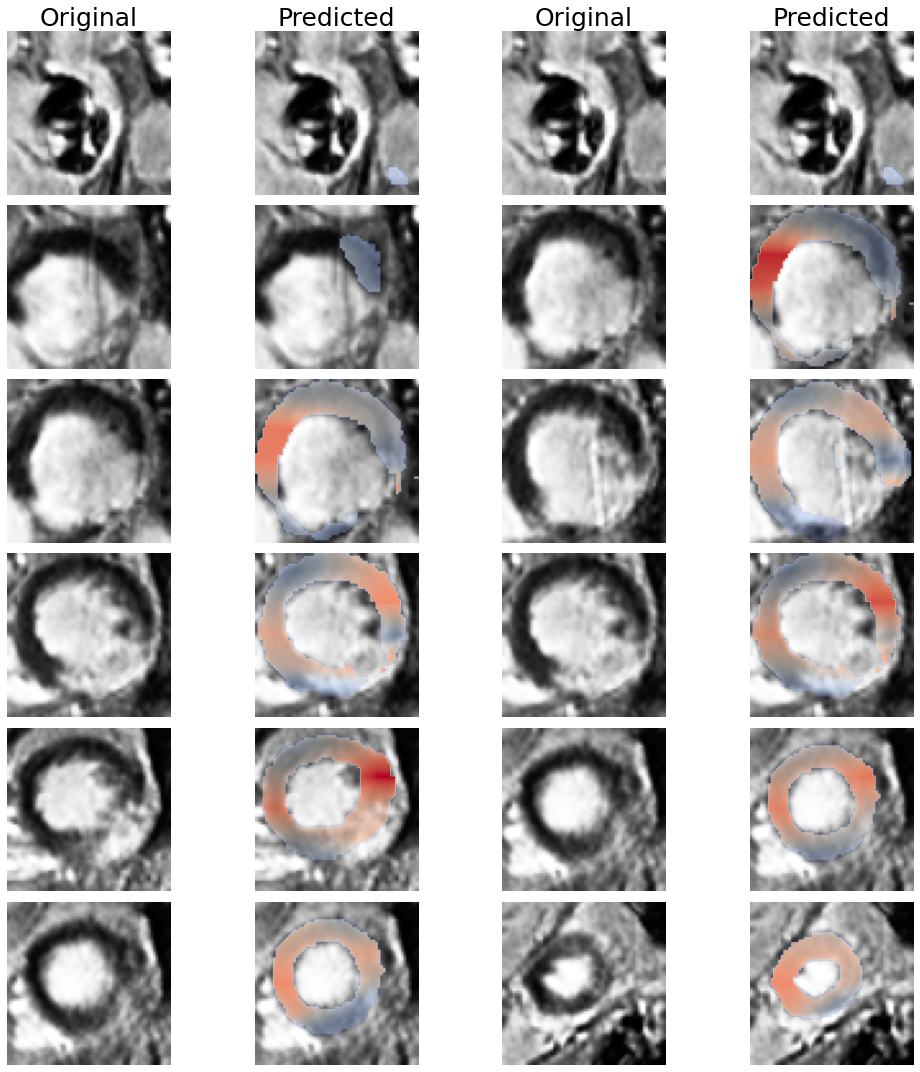

In [23]:
from __future__ import print_function
from collections import OrderedDict
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os
import numpy as np

def is_circle(binary_mask, circularity_threshold=0.2):
    binary_mask = binary_mask.astype(bool)

    circles = cv2.HoughCircles(
        binary_mask.astype(np.uint8),
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=5,
        param2=25, 
        minRadius=10,
        maxRadius=30
    )

    if circles is not None and len(circles[0]) > 0:
        circle = circles[0, 0]
        center = (int(circle[0]), int(circle[1]))
        radius = int(circle[2])
        area_circle = np.pi * radius**2
        circularity = area_circle / (np.pi * radius**2)
        if circularity > circularity_threshold:
            return center, radius
    return None

plt.ioff()
%matplotlib inline
def visualize_attention_maps_mri(vae, X_MRI_normalized, patient_id, cmap_set='jet', target_layer='encoder.16.conv2', num_cols=4, list_of_latents=[], low_value_threshold=0.001):
    attention_visualizer = attribute_wise_attn(vae, target_layer=target_layer)
    input_example = torch.tensor(X_MRI_normalized[patient_id:patient_id+1, :, :, :]).to('cuda')
    input_example = input_example.to(torch.float32)
    x_recon, z, _, _ = vae(input_example)
    attention_maps = []
    for latent in list_of_latents:
        attention_visualizer.backward(z, latent)
        attention_map = attention_visualizer.generate()
        attention_maps.append(attention_map)
    attention_maps = np.mean(attention_maps, axis=0)
    
    selected_slices = []
    for i, slice_data in enumerate(X_MRI_normalized[patient_id]):
        slice_data = slice_data[:, :, 0]
        attention_map_slice = attention_maps[i, :, :]
        binary_mask = X_MRI_normalized[patient_id, i, :, :, 1] > .15

        selected_slices.append(i)
    num_slices = len(selected_slices)
    num_rows = (num_slices + num_cols - 1) // num_cols
    attention_maps_min = np.min(attention_maps)
    attention_maps_max = np.max(attention_maps)
    attention_maps = (attention_maps - attention_maps_min) / (attention_maps_max - attention_maps_min)

    global_min = attention_maps.min()
    global_max = attention_maps.max()
    fig, axes = plt.subplots(num_rows, 2 * num_cols, figsize=(15, 15))
    fig.subplots_adjust(wspace=0.5, hspace=0.2)
    fig.tight_layout()
    
    axes[0, 0].set_title("Original", fontsize=25)
    axes[0, 1].set_title("Predicted", fontsize=25)
    axes[0, 2].set_title("Original", fontsize=25)
    axes[0, 3].set_title("Predicted", fontsize=25)
    
    for i, index in enumerate(selected_slices):
        row = i // num_cols
        col = i % num_cols
        ax_original = axes[row, 2 * col]
        ax_original.imshow(X_MRI_normalized[patient_id, index, :, :, 0], cmap='gray')
        ax_original.axis('off')
        ax = axes[row, 2 * col + 1]
        attention_map_slice = attention_maps[index, :, :]
        binary_mask = X_MRI_normalized[patient_id, index, :, :, 1] > .5
        masked_image = np.copy(X_MRI_normalized[patient_id, index, :, :, 0])
        masked_image[~binary_mask] = 0
        alpha_mask = attention_map_slice / np.max(attention_map_slice)
        alpha_mask[~binary_mask] = 0 
        masked_image[binary_mask] = attention_map_slice[binary_mask] 
        ax.imshow(X_MRI_normalized[patient_id, index, :, :, 0], cmap='gray', alpha=1)
        im = ax.imshow(masked_image, cmap=cmap_set, alpha=alpha_mask, vmin=global_min, vmax=global_max)
        ax.axis('off')
 
    for i in range(len(selected_slices), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, 2 * col])
        fig.delaxes(axes[row, 2 * col + 1])
    plt.ioff()

    plt.tight_layout()
    plt.show()
    plt.close()
    
plt.ioff()
%matplotlib inline

visualize_attention_maps_mri(vae_mri.to(device), all_mri_grad, patient_id=2, 
                                 target_layer='encoder.16.conv2', num_cols=2, cmap_set = 'coolwarm',
                                 list_of_latents=selected_mri,
                                 low_value_threshold=0.0)

# Virtual heart for factor traversal


In [5]:
from VAEres3d_mri_unsuper import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae_mri = VAE(latent_dim=256, red=1, drop=0).to(device)
path_weights = r'\\weights_vae_lge_256.pt'
vae_mri.load_state_dict(torch.load(path_weights))

<All keys matched successfully>

In [6]:
import numpy as np
import torch

X = np.load('overall_X_data.npy')
X_cut = X[:, -256:]
factor_numbers = [24, 239, 237, 90, 84, 197, 16, 199, 205, 154]
decoded_outputs_low = [[] for _ in factor_numbers]
decoded_outputs_mid = [[] for _ in factor_numbers]
decoded_outputs_high = [[] for _ in factor_numbers]

for factor_number_idx, factor_idx in enumerate(factor_numbers):
    factor = X_cut[:, factor_idx]
    
    mean_value = np.mean(factor)
    std_value = np.std(factor)
    low = mean_value - 3 * std_value
    high = mean_value + 3 * std_value   
    mean_value = np.mean(factor)
    traverse_range = np.array([low, mean_value, high])

    for i, traverse_value in enumerate(traverse_range):
        for sample_idx in range(X_cut.shape[0]):
            sample = X_cut[sample_idx, :].copy()
            sample = sample[np.newaxis, :]
            sample[:, factor_idx] = traverse_value
            encoded_traverse = torch.Tensor(sample).to(device)
            with torch.no_grad():
                decoded_output = vae_mri.decode(encoded_traverse)
                if i == 0:
                    decoded_outputs_low[factor_number_idx].append(decoded_output)
                elif i == 1:
                    decoded_outputs_mid[factor_number_idx].append(decoded_output)
                elif i == 2:
                    decoded_outputs_high[factor_number_idx].append(decoded_output)

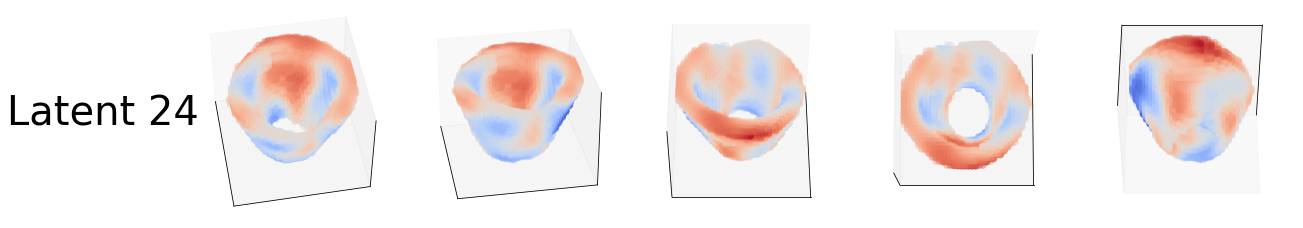

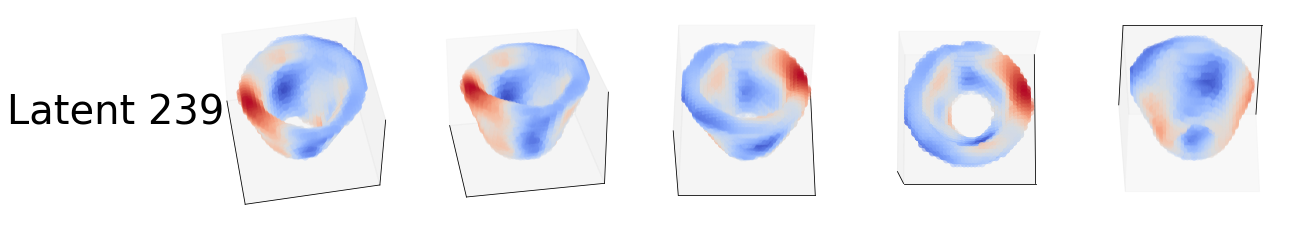

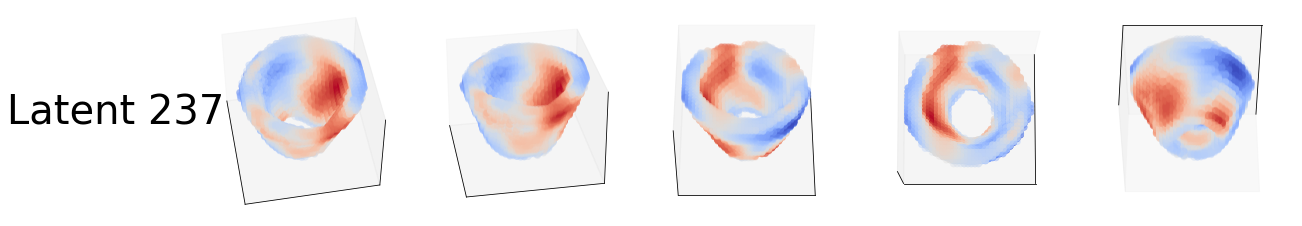

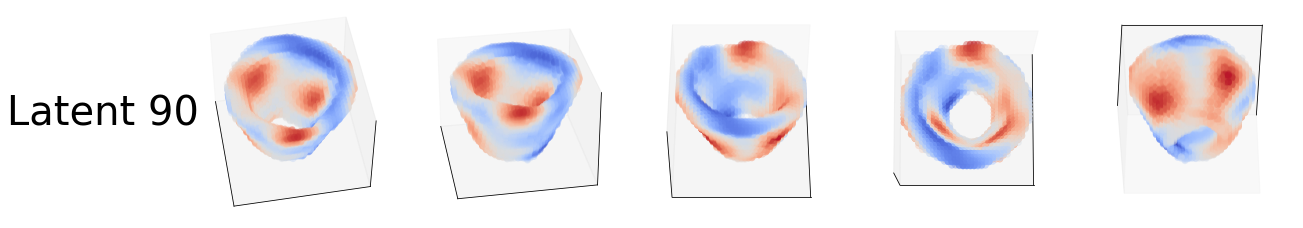

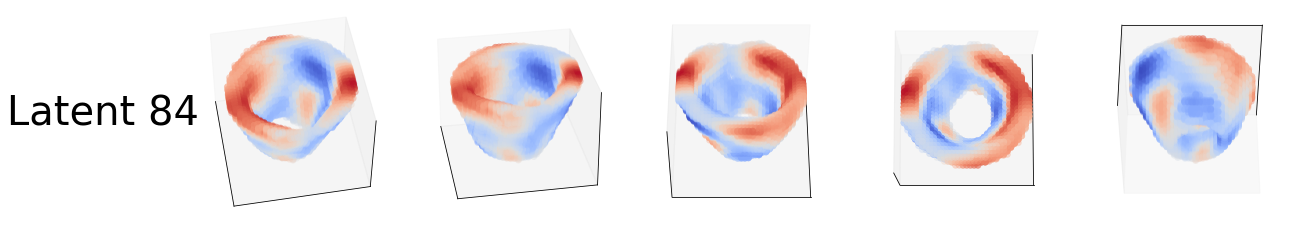

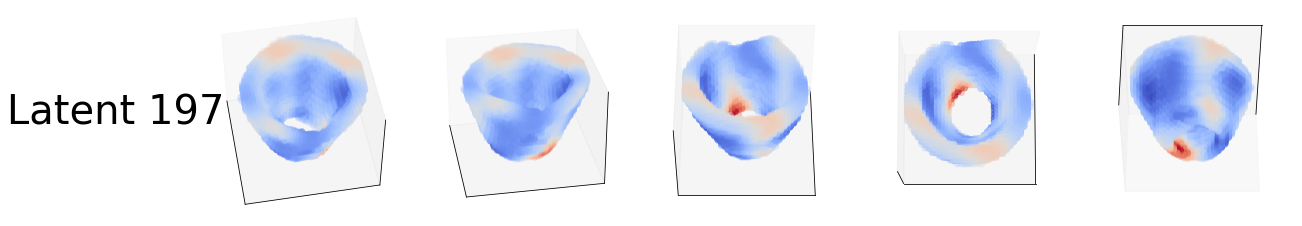

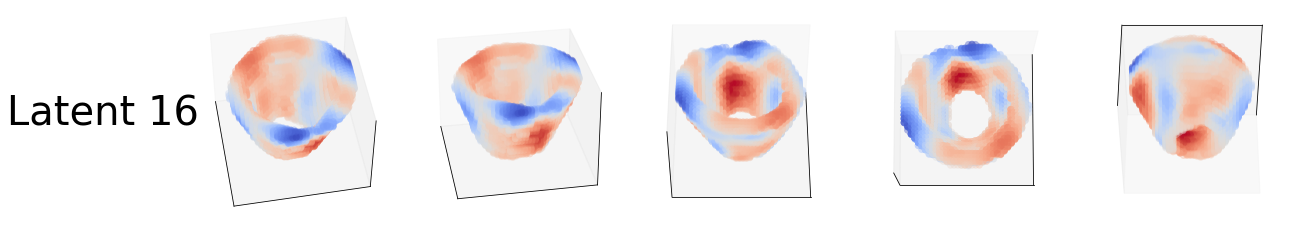

In [7]:
from matplotlib.colors import Normalize
import PIL
from PIL import Image
import numpy as np

latents = [0,1,2,3,4,5,6]

for factor in latents:
    alpha = 0.4
    import torch
    factor = factor
    lists_of_mris = [decoded_outputs_low[factor], decoded_outputs_mid[factor], decoded_outputs_high[factor]]

    averaged_mris = []

    for mris in lists_of_mris:
        averaged_mri = np.mean([mri.cpu().detach().numpy() for mri in mris], axis=0)
        averaged_mris.append(averaged_mri)

    low, mid, high = averaged_mris

    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.interpolate import interp1d
    from scipy.ndimage import zoom

    # Extracting the segmented ventricle from each dataset
    mri_data_low = low[0, :, :, :, 1]
    mri_data_mid = mid[0, :, :, :, 1]
    mri_data_high = high[0, :, :, :, 1]

    orignal_pixel_value_low = low[0, :, :, :, 0]
    orignal_pixel_value_mid = mid[0, :, :, :, 0]
    orignal_pixel_value_high = high[0, :, :, :, 0]

    new_num_slices = 100
    original_num_slices = mri_data_low.shape[0]
    original_slices = np.arange(original_num_slices)
    interpolator_low = interp1d(original_slices, mri_data_low, kind='linear', axis=0, fill_value="extrapolate")
    interpolator_mid = interp1d(original_slices, mri_data_mid, kind='linear', axis=0, fill_value="extrapolate")
    interpolator_high = interp1d(original_slices, mri_data_high, kind='linear', axis=0, fill_value="extrapolate")

    new_slices = np.linspace(0, original_num_slices - 1, new_num_slices)
    mri_data_low = interpolator_low(new_slices)
    mri_data_mid = interpolator_mid(new_slices)
    mri_data_high = interpolator_high(new_slices)

    interpolator_low = interp1d(original_slices, orignal_pixel_value_low, kind='linear', axis=0, fill_value="extrapolate")
    interpolator_mid = interp1d(original_slices, orignal_pixel_value_mid, kind='linear', axis=0, fill_value="extrapolate")
    interpolator_high = interp1d(original_slices, orignal_pixel_value_high, kind='linear', axis=0, fill_value="extrapolate")


    threshold = 0.5 
    target_size = (64, 64)  

    binary_mask_low = (mri_data_low > threshold).astype(int)
    binary_mask_mid = (mri_data_mid > threshold).astype(int)
    binary_mask_high = (mri_data_high > threshold).astype(int)

    pixelvalue_low = interpolator_low(new_slices)
    pixelvalue_mid = interpolator_mid(new_slices)
    pixelvalue_high = interpolator_high(new_slices)

    resized_binary_masks_low = []
    resized_binary_masks_mid = []
    resized_binary_masks_high = []

    resized_pixel_masks_low = []
    resized_pixel_masks_mid = []
    resized_pixel_masks_high = []

    zoom_factor = 0.9

    for i in range(binary_mask_mid.shape[0]):
        mask_low = zoom(binary_mask_low[i, :, :], zoom_factor, mode='nearest')
        mask_mid = zoom(binary_mask_mid[i, :, :], zoom_factor, mode='nearest')
        mask_high = zoom(binary_mask_high[i, :, :], zoom_factor, mode='nearest')

        mask_pixellow = zoom(pixelvalue_low[i, :, :], zoom_factor, mode='nearest')
        mask_pixelmid = zoom(pixelvalue_mid[i, :, :], zoom_factor, mode='nearest')
        mask_pixelhigh = zoom(pixelvalue_high[i, :, :], zoom_factor, mode='nearest')

        pad_low = ((target_size[0] - mask_low.shape[0]) // 2, (target_size[1] - mask_low.shape[1]) // 2)
        pad_mid = ((target_size[0] - mask_mid.shape[0]) // 2, (target_size[1] - mask_mid.shape[1]) // 2)
        pad_high = ((target_size[0] - mask_high.shape[0]) // 2, (target_size[1] - mask_high.shape[1]) // 2)

        mask_low_resized = np.pad(mask_low, ((pad_low[0], pad_low[0]), (pad_low[1], pad_low[1])), mode='constant', constant_values=0)
        mask_mid_resized = np.pad(mask_mid, ((pad_mid[0], pad_mid[0]), (pad_mid[1], pad_mid[1])), mode='constant', constant_values=0)
        mask_high_resized = np.pad(mask_high, ((pad_high[0], pad_high[0]), (pad_high[1], pad_high[1])), mode='constant', constant_values=0)

        mask_pixellow_resized = np.pad(mask_pixellow, ((pad_low[0], pad_low[0]), (pad_low[1], pad_low[1])), mode='constant', constant_values=0)
        mask_pixelmid_resized = np.pad(mask_pixelmid, ((pad_mid[0], pad_mid[0]), (pad_mid[1], pad_mid[1])), mode='constant', constant_values=0)
        mask_pixelhigh_resized = np.pad(mask_pixelhigh, ((pad_high[0], pad_high[0]), (pad_high[1], pad_high[1])), mode='constant', constant_values=0)

        if mask_low_resized.shape != target_size:
            mask_low_resized = np.pad(mask_low_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)
            mask_pixellow_resized = np.pad(mask_pixellow_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)

        if mask_mid_resized.shape != target_size:
            mask_mid_resized = np.pad(mask_mid_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)
            mask_pixelmid_resized = np.pad(mask_pixelmid_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)

        if mask_high_resized.shape != target_size:
            mask_high_resized = np.pad(mask_high_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)
            mask_pixelhigh_resized = np.pad(mask_pixelhigh_resized, ((0, 1), (0, 1)), mode='constant', constant_values=0)

        resized_binary_masks_low.append(mask_low_resized)
        resized_binary_masks_mid.append(mask_mid_resized)
        resized_binary_masks_high.append(mask_high_resized)

        resized_pixel_masks_low.append(mask_pixellow_resized)
        resized_pixel_masks_mid.append(mask_pixelmid_resized)
        resized_pixel_masks_high.append(mask_pixelhigh_resized)

        zoom_factor = zoom_factor - 0.006
        
    resized_pixel_masks_low = np.stack(resized_pixel_masks_low)
    resized_pixel_masks_mid = np.stack(resized_pixel_masks_mid)
    resized_pixel_masks_high = np.stack(resized_pixel_masks_high)

    binary_mask_low = np.stack(resized_binary_masks_low)
    binary_mask_mid = np.stack(resized_binary_masks_mid)
    binary_mask_high = np.stack(resized_binary_masks_high)

    coords_low = np.array(np.nonzero(binary_mask_low)).T
    coords_mid = np.array(np.nonzero(binary_mask_mid)).T
    coords_high = np.array(np.nonzero(binary_mask_high)).T

    from matplotlib import cm
    from scipy.ndimage import gaussian_filter

    fig, axs = plt.subplots(1, 5, figsize=(18, 10), subplot_kw={'projection': '3d'})
    fig.subplots_adjust(wspace=0.2, hspace=0.0)
    s = 50

    def normalize(arr):
        min_val = arr.min()
        max_val = arr.max()
        normalized_arr = (arr - min_val) / (max_val - min_val)
        return normalized_arr

    normalized_high = normalize(resized_pixel_masks_high)
    normalized_low = normalize(resized_pixel_masks_low)
    intensity_diff = normalized_high - normalized_low
    sigma = 2.0  # You can adjust the value of sigma as needed
    intensity_diff = gaussian_filter(intensity_diff, sigma=sigma)
    sm_resized_pixel_masks_high = gaussian_filter(resized_pixel_masks_high, sigma=sigma)
    sm_resized_pixel_masks_low = gaussian_filter(resized_pixel_masks_low, sigma=sigma)
    angles = [(50, 170), (30, 170), (50,0), (80,0), (-40,0)]
    for i, angle in enumerate(angles):
        ax_diff = axs[i]

        merged_coords = np.concatenate((coords_low, coords_high), axis=0)

        norm = Normalize(vmin=intensity_diff.min(), vmax=intensity_diff.max())
        normalized_intensity = norm(intensity_diff)


        ax_diff.scatter(merged_coords[:, 1] * -1, merged_coords[:, 2] * -1, merged_coords[:, 0] * -1,
                        c=np.abs(normalized_intensity[merged_coords[:, 0], merged_coords[:, 1], merged_coords[:, 2]]), s=s,
                       cmap='coolwarm', edgecolor='none', alpha=alpha, label='Coords Low')

        ax_diff.set_xlabel('')
        ax_diff.set_ylabel('')
        ax_diff.set_zlabel('')
        ax_diff.view_init(elev=angle[0], azim=angle[1])
        ax_diff.set_xticks([])
        ax_diff.set_yticks([])
        ax_diff.set_zticks([])

    for i in range(1):
        axs[i].text2D(-0.36, 0.5, f'Latent {factor_numbers[factor]}', transform=axs[i].transAxes, fontsize=40, rotation='horizontal', va='center', ha='center')
    plt.tight_layout()
    plt.show()


# ECG factor traversal

In [2]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from VAEresnet_electrocar_2d import VAE, VAE_Loss
vae_ecg = VAE(latent_dim=32, red=1).to(device)
final_model_path = r"\VAE2d-ECG weights.pt"
vae_ecg.load_state_dict(torch.load(final_model_path))

<All keys matched successfully>

In [3]:
from matplotlib.colors import Normalize
X = np.load('overall_X_data.npy')
X_cut = X[:, 33:65] #Get one patient
factor_numbers = [29, 1, 17, 24, 16, 18, 13]
individual = False
population = True
decoded_outputs=[]

decoded_ecg_low = [[] for _ in factor_numbers]
decoded_ecg_mid = [[] for _ in factor_numbers]
decoded_ecg_high = [[] for _ in factor_numbers]

for factor_number_idx, factor_idx in enumerate(factor_numbers):
    factor = X_cut[:, factor_idx]
    low = np.mean(factor) - 3
    high = np.mean(factor) +  3 
    mean_value = np.mean(factor) 
    
    traverse_range = np.array([low, mean_value, high])
    cmap = plt.get_cmap('coolwarm')
    norm = Normalize(vmin=-1, vmax=1)  
    low_color = cmap(0.0)
    high_color = cmap(9.0)
    for i, traverse_value in enumerate(traverse_range):
        if individual:
            sample = X_cut[patient_idx:patient_idx + 1, :].copy()
        elif population:
            for sample_idx in range(X_cut.shape[0]):
                sample = X_cut[sample_idx, :].copy()
                sample = sample[np.newaxis, :]
                sample[:, factor_idx] = traverse_value
                encoded_traverse = torch.Tensor(sample).to(device)
                with torch.no_grad():
                    decoded_output = vae_ecg.decode(encoded_traverse)
                if i == 0:
                    decoded_ecg_low[factor_number_idx].append(decoded_output)
                elif i == 1:
                    decoded_ecg_mid[factor_number_idx].append(decoded_output)
                elif i == 2:
                    decoded_ecg_high[factor_number_idx].append(decoded_output)

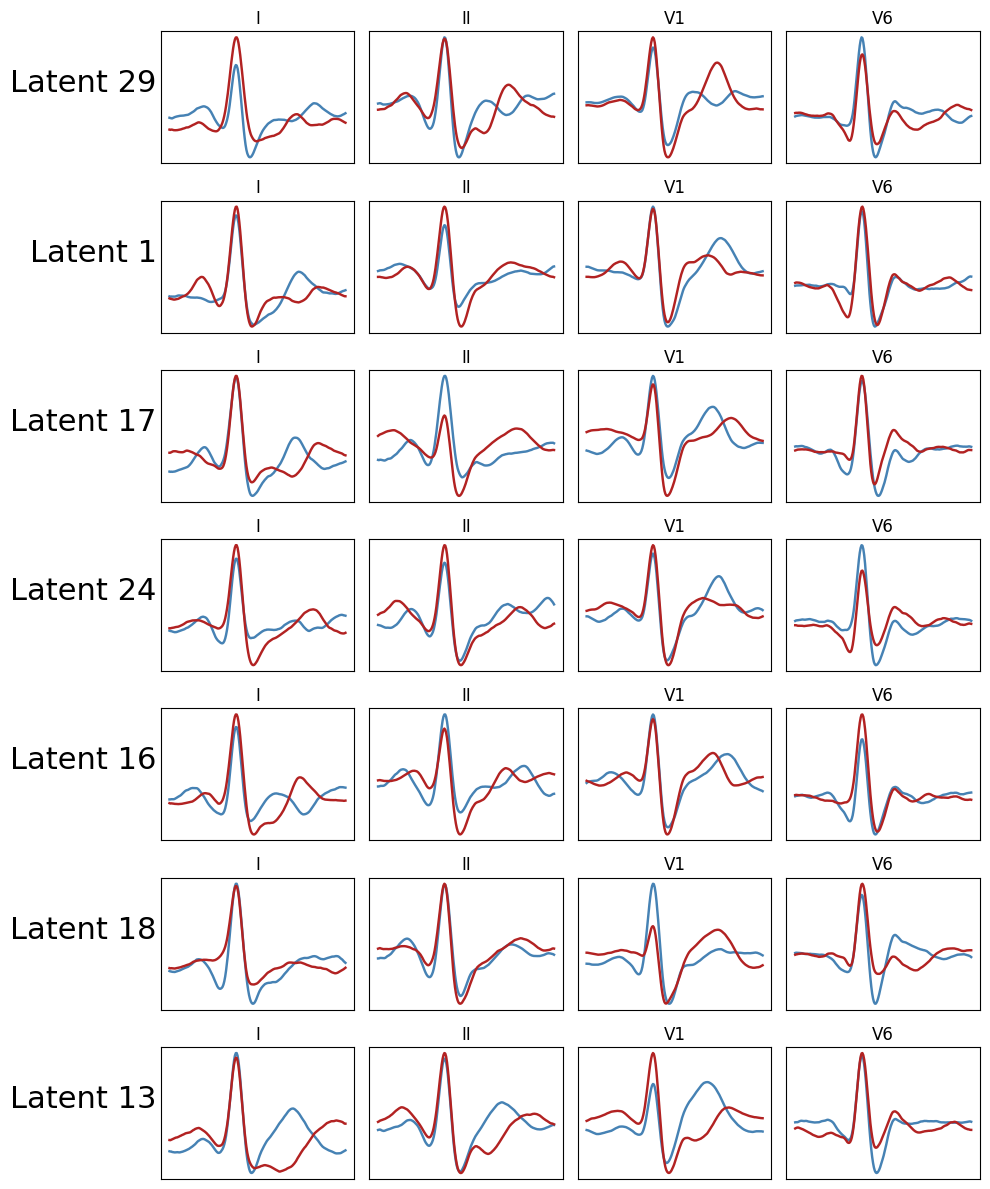

In [8]:
colors = ['steelblue', 'dimgray', 'firebrick']

def smooth_signal(signal, window_size=10):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')
fig, axes = plt.subplots(len(factor_numbers), 4, figsize=(10,12))
fig.patch.set_facecolor('white')
fig.subplots_adjust(hspace=0.5)

for factor_idx in range(len(factor_numbers)):
    sigs_low = []
    sigs_mid = []
    sigs_high = []

    for i in range(12):
        lead_sigs_low = [decoded_ecg_low[factor_idx][j][0, 0, i, :].cpu().detach().numpy() for j in range(X.shape[0])]
        lead_sigs_mid = [decoded_ecg_mid[factor_idx][j][0, 0, i, :].cpu().detach().numpy() for j in range(X.shape[0])]
        lead_sigs_high = [decoded_ecg_high[factor_idx][j][0, 0, i, :].cpu().detach().numpy() for j in range(X.shape[0])]

        mean_low = np.mean(lead_sigs_low, axis=0)
        mean_mid = np.mean(lead_sigs_mid, axis=0)
        mean_high = np.mean(lead_sigs_high, axis=0)

        smooth_mean_low = smooth_signal(mean_low)
        smooth_mean_mid = smooth_signal(mean_mid)
        smooth_mean_high = smooth_signal(mean_high)

        sigs_low.append(smooth_mean_low)
        sigs_mid.append(smooth_mean_mid)
        sigs_high.append(smooth_mean_high)

    mean_low = np.stack(sigs_low, axis=1)
    mean_mid = np.stack(sigs_mid, axis=1)
    mean_high = np.stack(sigs_high, axis=1)

    leads = [0, 1, 6, 11]
    lead_names = ['I',  'II' , 'V1', 'V6']
    for count, i in enumerate(leads):
        axes[factor_idx, count].plot(mean_low[5:-5, i], linestyle='-', color=colors[0], linewidth=1.75, alpha=1, label='Low')
        axes[factor_idx, count].plot(mean_high[5:-5, i], linestyle='-', color=colors[2], linewidth=1.75, alpha=1, label='High')
        axes[factor_idx, count].grid(True, linewidth=4, color='gray', linestyle='--')
        axes[factor_idx, count].set_xlabel('')
        axes[factor_idx, count].set_title(lead_names[count])
        axes[factor_idx, count].set_ylabel('')
        axes[factor_idx, count].set_xticks([])
        axes[factor_idx, count].set_yticks([])
    axes[factor_idx, 0].set_ylabel(f'Latent {factor_numbers[factor_idx]}', fontsize=22, labelpad=3, rotation=0, ha='right')
plt.tight_layout()
plt.show()